# Google Colabの設定

In [1]:
# setting for Google Colab
!git clone https://github.com/hayamatomoe/WeaveSynthesizer.git
import os
path = '/content/WeaveSynthesizer'
os.chdir(path)
!ls
from google.colab import drive
drive.mount('/content/drive')
%mkdir img

Cloning into 'WeaveSynthesizer'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 26 (delta 5), reused 16 (delta 2), pack-reused 0
Unpacking objects: 100% (26/26), done.
README.md  sample.ipynb  torchweave  tutorial_J1.ipynb
Mounted at /content/drive


# ライブラリの読み込み

In [13]:
# import libraries
import torchweave.structures as tws
import torchweave.functions as twf
import importlib
import functools
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

# 緯糸(weft)，経糸(warp)の本数設定

- `multWeave`: 多重織りの層数．
- `thrLen`: 綜絖(threading)に通す経糸の本数．織機に応じて設定．
- `trdLen`: 踏み木(treadling)の踏み方．越の数．
- `tuLen`: タイアップのサイズ．自由に設定．値が小さいほど模様が粗い．
- `asp`: 画像表示するときのアスペクト比．太さの比を経糸:緯糸=3.8:1に設定している．

2色の緯糸，一重織りで，グラデーション織りをつくる


In [14]:
multWeave = 1
# thrLen = 2000//multWeave # warp 9024px=150cm
thrLen = 9024//multWeave # warp 9024px=150cm
# n2:9024
# n4:5120
# n6:4608
trdLen = 512 # weft 1152px=70cm, 500cm=8228, 800cm=12665
# trdLen = 12665 # weft 1152px=70cm, 500cm=8228, 800cm=12665
tuLen = 512
asp=trdLen*3.8/(thrLen*multWeave)

# 多重織りの基底になる波形と濃度マップ
綜絖，踏み木の波形を生成．`torchWeave`ライブラリ`Wav`クラスのオブジェクトを生成．

## 波形
- `func1a`: 踏み木の波形$f_{1,a}(x)$
- `func1b`: 綜絖の波形$f_{1,b}(x)$

`.plot`で踏み木・綜絖それぞれの波形を描画．後でこの２つの波形から行列をつくって積をとる．

## 濃度マップ
パラメータ`a`をとり，`.density`でfloat配列`b1`をつくってplotすれば，2つの波形から平面グラデーションができる．これは２変数関数$f_1(x,y)=|f_{1,b}(x)-\mod(af_{1,a}(y),1)|$の濃度マップである．二色の緯糸を使ってこのグラデーションをつくる．

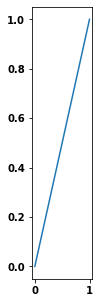

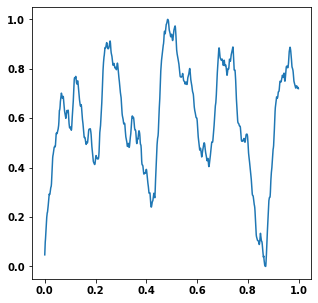

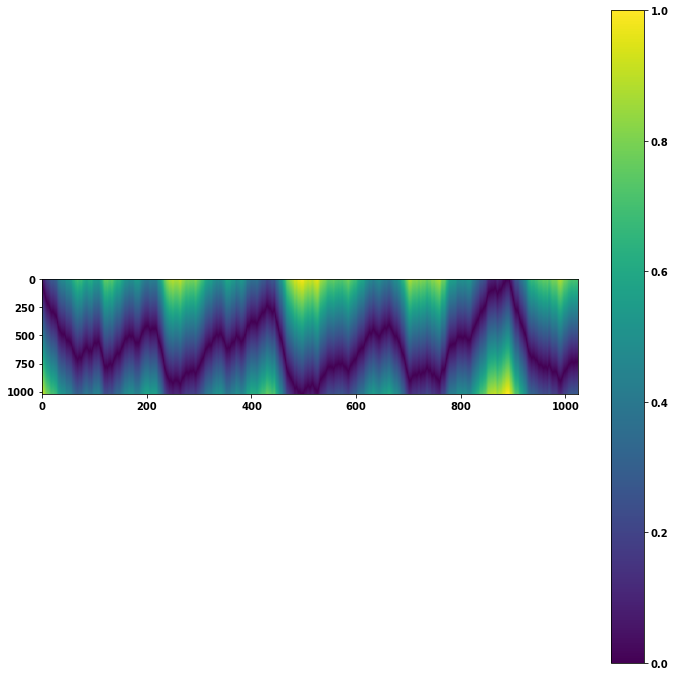

In [15]:

def func1a(x):
    return x

wav1a=tws.Wav(func1a)   
wav1a.plot(aspect=asp)

def func1b(x):
    freq =6
    func=functools.partial(twf.fbm, H=1., freq=freq, phase=74, itr=7, func=twf.vnoise_)
    n = twf.warp(x, func=func, wt=.1/freq, itr=2)
    s = twf.fbm(x, H=1., freq=freq*1.5, phase=0, itr=6, func=twf.sin_)
    return torch.lerp(n, s, 0.3)

wav1b=tws.Wav(func1b)   
wav1b.plot()

b1 = tws.density(wav1a,wav1b, a=1)
tws.densityplot(b1, aspect=asp, bar = True)


## 緯糸の色
杼番と色．各レイヤーごとに2色の緯糸でグラデーション．

In [35]:
#RGB color
weft1 = [0,1,0] #green
weft2 = [0,0,1] #blue

# 綜絖(thread), 踏み木(treadling)の行列生成
綜絖と踏み木の行列は，波形から綾織りをもとにつくる．綾の本数`line`によって，波形の滑らかさが変わる．`line`が少ないほど綾織りに近い．

- `thr, trd`は`Tensor`クラスのオブジェクト
    - `thr`のサイズは`(tuLen,thrLen)`
    - `trd`のサイズは`(tuLen,trdLen)`
    - `.plot`で描画，オプション`save=True`で保存．`name=''`でファイル名追加．

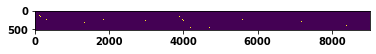

<Figure size 1440x1440 with 0 Axes>

21-0325-1200-49136579_thr_


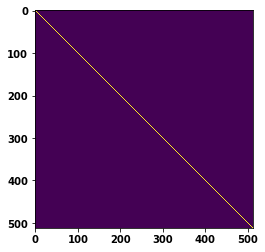

<Figure size 1440x1440 with 0 Axes>

21-0325-1200-49414834_trd_


In [36]:
importlib.reload(tws)
line=32
thr1=wav1b.sparse(wd=thrLen, ht=tuLen, n=line)
trd1=wav1a.sparse(wd=trdLen, ht=tuLen, n=line)

thr1.plot(save=True, name='thr')
trd1.plot(save=True, name='trd')

# タイアップの行列生成
タイアップは正方行列からなる．これは次のようにつくる．

1. 数列を生成
1. 数列からバイナリ数列を生成
1. 生成したバイナリ数列をずらしながら正方行列をつくる

このプログラムではタイアップにぼかし織りをつくる．

## 数列生成のための関数

In [37]:
importlib.reload(tws)
def shade(n, step=1):
    a = torch.arange(1,1+n//2, step)
    a_ = n-a
    a_ = a_.flip(0)
    b = torch.cat([a, a_], 0).reshape(1,-1)
    c = torch.cat([sym(b),sym(b.flip(1))], 0).reshape(1,-1)
    return c
def sym(s):
    c = torch.cat([s,s.flip(1)],0)
    c = c.transpose(0,1).flatten()
    return c
def reverse(s):
    zero = torch.tensor([[0]])
    return torch.cat([zero, s], dim=1)

## ぼかし織り数列
$a=[1,n-1,2,n-2,...,\lfloor n/2\rfloor, \lceil n/2\rceil]$
$b=[n-1,1,n-2,2,..., \lceil n/2\rceil,\lfloor n/2\rfloor]$

`shade(n)`: a<>flip(a)<>b<>flip(b)

nが偶数のとき，すべての和は$n\times n\times 2$


In [38]:
seq=shade(4)
print(seq)
print(torch.sum(seq))
print(reverse(seq))

tensor([[1, 3, 2, 2, 2, 2, 3, 1, 3, 1, 2, 2, 2, 2, 1, 3]])
tensor(32)
tensor([[0, 1, 3, 2, 2, 2, 2, 3, 1, 3, 1, 2, 2, 2, 2, 1, 3]])


`seq`クラスオブジェクトの数列からバイナリ数列をつくる．
- `[2,2,2]`->`[1,1,0,0,1,1]`
- `[0,2,1,3]`->`[0,0,1,0,0,0]`

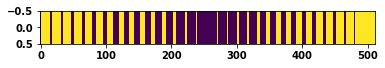

<Figure size 1440x1440 with 0 Axes>

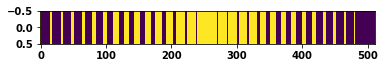

<Figure size 1440x1440 with 0 Axes>

In [39]:
importlib.reload(tws)
tuSeq1_ = shade(16)
tuSeq1r_ = reverse(tuSeq1_)
tuSeq1 = tws.Seq(tuSeq1_)
tuSeq1r = tws.Seq(tuSeq1r_)
tuSeq1.plot(wd=tuLen)
tuSeq1r.plot(wd=tuLen)

## 色シミュレーションの設定

In [40]:
# color simulation
w1tensor = torch.tensor(weft1, dtype=torch.uint8).reshape(1,1,1,3)*255
w2tensor = torch.tensor(weft2, dtype=torch.uint8).reshape(1,1,1,3)*255

color1 = torch.cat([w1tensor,w2tensor], 0).cuda()
color1_back = torch.flip(color1,(0,))


# ぼかし織りテンソル生成

多重織りの各レイヤーごとにぼかし織り数列(表・裏)をずらしてテンソルをつくる．

- 各レイヤーごとに，上でつくったぼかし織り数列(表・裏)をくっつけてテンソルをつくる
- テンソルを`.roll`でずらして，テンソルの階数を増やす
    - パラメータの配列はずらし方の数列．綾織りの綾の角度．
        - `[1]`なら１つずつ右にずれる
        - `[-1,2]`なら1つずつ「左にずれる」「2つずつ右にずれる」を交互に繰り返す
    - オプション変数`diff`で，さらに配列`[n,m]`の分だけずらす．
        - i行目を`i*n%m`だけずらす
- `tu1`は`Tensor`クラスのオブジェクト
    - サイズは`(2,tuLen,tuLen)`
    


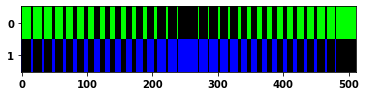

<Figure size 1440x1440 with 0 Axes>

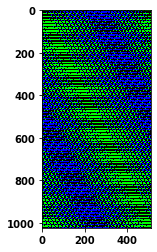

<Figure size 1440x1440 with 0 Axes>

In [41]:
n=5
tu_sat = [0,11]
tu_sat_ = [n,11]
s = tuSeq1.copy()
s.append(tuSeq1r)
s.plot(color=color1, wd=tuLen)
tu1 = s.roll([1], diff = tu_sat, wd=tuLen)
tu1.plot(color=color1)

# テンソル演算
上でつくった綜絖，踏み木，タイアップのテンソルをかける．

## 計算例
次のようなテンソルに対して，

$A=\begin{pmatrix}1&0&1\\0&1&0\end{pmatrix},\quad 
B=\left(\begin{pmatrix}1&0\\1&1\end{pmatrix}, \begin{pmatrix}0&1\\0&0\end{pmatrix}\right)=\left(B_1,B_2\right),\quad 
C=\begin{pmatrix}1&1&0\\0&0&1\end{pmatrix}$

次のように計算する．

$\mathrm{mul}(A,B,C)=\left({}^tA.B_1.C, {}^tA.B_2.C\right)=
\left(
    \begin{pmatrix}1&1&0\\1&1&1\\1&1&0\end{pmatrix},
    \begin{pmatrix}0&0&1\\0&0&0\\0&0&1\end{pmatrix}
\right)
$



A


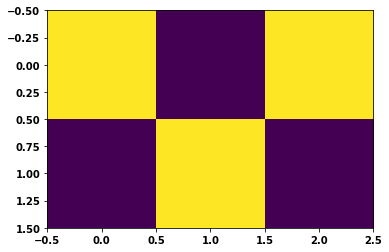

<Figure size 1440x1440 with 0 Axes>

B


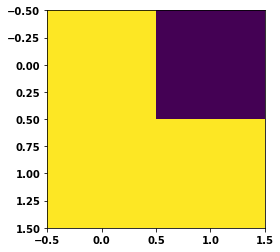

<Figure size 1440x1440 with 0 Axes>

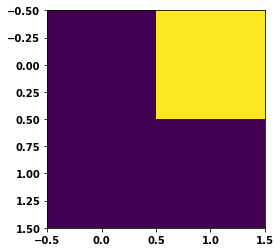

<Figure size 1440x1440 with 0 Axes>

C


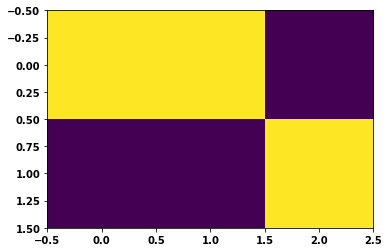

<Figure size 1440x1440 with 0 Axes>

mul(A,B,C)


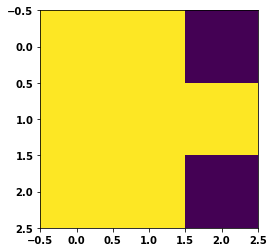

<Figure size 1440x1440 with 0 Axes>

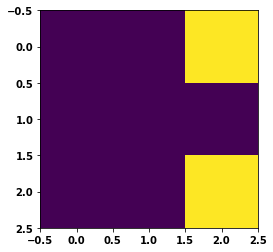

<Figure size 1440x1440 with 0 Axes>

In [42]:
A = tws.Tensor(
    [
        [1,0,1],
        [0,1,0]
    ]
)
print('A')
A.plot()
B = tws.Tensor(
    [
        [
            [1,0],
            [1,1]
        ],
        [
            [0,1],
            [0,0]
        ],
    ]
)
print('B')
B.plot()
C = tws.Tensor(
    [
        [1,1,0],
        [0,0,1]
    ]
)
print('C')
C.plot()
print('mul(A,B,C)')
P = tws.matmul(A,B,C)
P.plot()


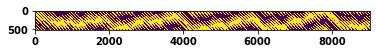

<Figure size 1440x1440 with 0 Axes>

21-0325-1200-51977985_lay1_


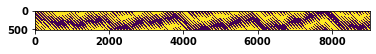

<Figure size 1440x1440 with 0 Axes>

21-0325-1200-51977985_lay1_


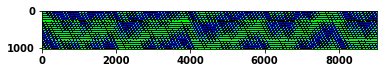

<Figure size 1440x1440 with 0 Axes>

21-0325-1200-52557438_color_


In [43]:
pat1 = tws.matmul(trd1, tu1, thr1)
pat1.plot(save=True, name='lay1') #binary
pat1.plot(save=True, color=color1) #color simulation